# New attempts at predicting Price using data split by YearSold and models proposed by Marta

## Imports

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load the dataset

In [32]:
data = pd.read_csv('After_feature_engineering.csv')
data.head()

,Suburb,Address,Rooms,Type,Price,SellerG,Date,Distance,Postcode,Bedroom2,...,RegionGroup_W_Metropolitan,RegionGroup_W_N_E_Victoria,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,Type_h,Type_t,Type_u
0,Abbotsford,85 Turner St,2,h,1480000.0,Biggin,2016-12-03,2.5,3067,2,...,False,False,False,True,False,False,False,True,False,False
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,Biggin,2016-02-04,2.5,3067,2,...,False,False,False,True,False,False,False,True,False,False
2,Abbotsford,5 Charles St,3,h,1465000.0,Biggin,2017-03-04,2.5,3067,3,...,False,False,False,False,False,True,False,True,False,False
3,Abbotsford,40 Federation La,3,h,850000.0,Biggin,2017-03-04,2.5,3067,3,...,False,False,True,False,False,False,False,True,False,False
4,Abbotsford,55a Park St,4,h,1600000.0,Nelson,2016-06-04,2.5,3067,3,...,False,False,False,False,False,False,True,True,False,False


### Dropping unnecessary columns

In [33]:
columns_to_drop = ['Suburb', 'Address', 'SellerG', 'Date', 'Postcode', 'Lattitude', 'Longtitude', 'Type', 'Bedroom2', 'Car', 'Regionname', 'YearBuilt', 'Car_Category','BuildingArea_missing']
data = data.drop(columns=columns_to_drop, errors='ignore')

data.head()

,Rooms,Price,Distance,Bathroom,Landsize,BuildingArea,Propertycount,Bedroom2_Group_0,Bedroom2_Group_1,Bedroom2_Group_2_3,...,RegionGroup_W_Metropolitan,RegionGroup_W_N_E_Victoria,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,Type_h,Type_t,Type_u
0,2,1480000.0,2.5,1,202.0,120.320408,4019,False,False,True,...,False,False,False,True,False,False,False,True,False,False
1,2,1035000.0,2.5,1,156.0,79.000000,4019,False,False,True,...,False,False,False,True,False,False,False,True,False,False
2,3,1465000.0,2.5,2,134.0,150.000000,4019,False,False,True,...,False,False,False,False,False,True,False,True,False,False
3,3,850000.0,2.5,2,94.0,97.551020,4019,False,False,True,...,False,False,True,False,False,False,False,True,False,False
4,4,1600000.0,2.5,1,120.0,142.000000,4019,False,False,True,...,False,False,False,False,False,False,True,True,False,False


## Model 3 - With log(price)

### Defining predictors and target variable

In [34]:
#Interaction terms
# Define interaction terms
data['BuildingArea*RegionGroup_E_Metropolitan'] = data['BuildingArea']*data['RegionGroup_E_Metropolitan']  
data['BuildingArea*RegionGroup_N_S_SE_Metropolitan'] = data['BuildingArea']*data['RegionGroup_N_S_SE_Metropolitan']  
data['BuildingArea*RegionGroup_W_Metropolitan'] = data['BuildingArea']*data['RegionGroup_W_Metropolitan']  



predictors = ['Rooms','Distance','Bathroom','Landsize',
          'Bedroom2_Group_1','Bedroom2_Group_2_3', 'Bedroom2_Group_4_5',
          'Bedroom2_Group_6_or_more', 'Car_1', 'Car_2', 'Car_3', 'Car_4',
          'HouseAge', 'BuildingArea*RegionGroup_E_Metropolitan',
          'BuildingArea*RegionGroup_N_S_SE_Metropolitan','BuildingArea*RegionGroup_W_Metropolitan', 
          'Method_PI', 'Method_SA', 'Method_SP', 'Method_VB', 'Type_t', 'Type_u']

### Splitting dataset into train and test sets by YearSold

In [35]:
# Filter the training and test data based on YearSold
train_data = data[data['YearSold'] == 2016]
test_data = data[data['YearSold'] == 2017]

print("Training set years:", train_data['YearSold'].unique())
print("Test set years:", test_data['YearSold'].unique())

Training set years: [2016]
Test set years: [2017]


### Separate predictors (X) and target variable (y) for train and test sets

In [36]:
X_train = train_data[predictors].values  
y_train = np.log(train_data['Price'])

X_test = test_data[predictors].values
y_test = np.log(test_data['Price'])

### Standardizing predictors

In [37]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Adding intercept column to vector of predictors

In [38]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (6225, 23)
Shape of X_test (with intercept): (6923, 23)


### Fixing data type

In [39]:
X_test = X_test.astype(float)
X_train = X_train.astype(float)

print("y_test dtype:", y_test.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

y_test dtype: float64
X_test dtype: float64
y_train dtype: float64
X_train dtype: float64


### Predictive Model

Defining the log_likelihood function, priors and posterior distributions. 

In [40]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

Next, we implement the MCMC Algorithm using Metropolis-Hastings to draw samples from the posterior distribution. 

Here I made two changes:
1. Under #Initialize parameters - previous version:
    >beta = np.zeros(n_params)
    >sigma2 = 1
2. Under #Propose a new beta and #Propose a new sigma - previous version:
     >#Propose a new beta
        >>beta_proposal = beta + np.random.normal(0,0.1,size=n_params)

    >#Propose a new sigma2
        >>sigma2_proposal = sigma2 + np.random.normal(0,0.1)
        >>sigma2_proposal = abs(sigma2_proposal) #variance > 0

In [41]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.random.normal(0, 0.1, size=n_params)
    sigma2 = np.abs(np.random.normal(1, 0.5))

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.5,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.5)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

Running the model

In [42]:
#Running the model
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_95115/3794734152.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)


Posterior Mean of coefficients: [ 1.36434849e+01  3.81936835e-01 -2.19790803e-01 -2.95056863e-01
 -7.67824034e-02  3.20360542e-01  9.03763587e-01  9.42132378e-01
  1.20756175e-01 -2.44529485e-01 -3.31427032e-01 -4.27943526e-01
 -3.99351667e-02  3.99731113e-01  1.50317666e-01  1.47352529e-01
 -1.33949383e-02  1.50259528e-01  3.30247519e-01 -1.09586185e-01
  1.75107486e-01  3.76509171e-01 -1.74210425e-01]
Posterior Mean of Variance: 8.4765578586574


Simple Checks on the model

In [43]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [44]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (6923, 23)
beta_mean shape: (23,)
Shape of X_train: (6225, 23)


### Predicting Price

In [45]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 605377726715.5085
Mean Squared Error: 2.5371355610743204e+27


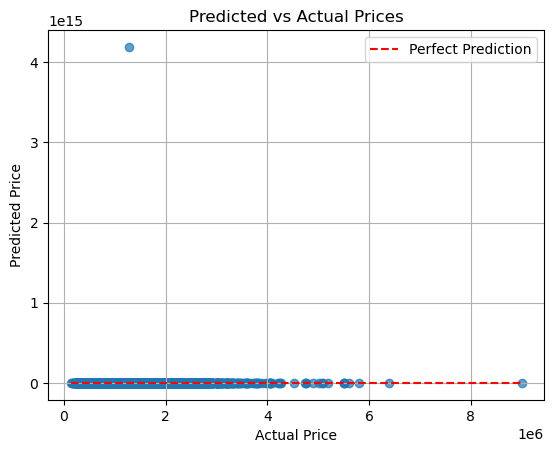

In [46]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

## Model 8

### Using log(Price)

### Defining predictors and target variable

In [47]:
#Interaction terms
# Define interaction terms
data['BuildingArea*RegionGroup_E_Metropolitan'] = data['BuildingArea']*data['RegionGroup_E_Metropolitan']  
data['BuildingArea*RegionGroup_N_S_SE_Metropolitan'] = data['BuildingArea']*data['RegionGroup_N_S_SE_Metropolitan']  
data['BuildingArea*RegionGroup_W_Metropolitan'] = data['BuildingArea']*data['RegionGroup_W_Metropolitan']
data['RegionGroup_W_Metropolitan*Method_PI']= data['RegionGroup_W_Metropolitan']*data['Method_PI']
data['RegionGroup_W_Metropolitan*Method_SA']= data['RegionGroup_W_Metropolitan']*data['Method_SA']
data['RegionGroup_W_Metropolitan*Method_SP']= data['RegionGroup_W_Metropolitan']*data['Method_SP']
data['RegionGroup_W_Metropolitan*Method_VB']= data['RegionGroup_W_Metropolitan']*data['Method_VB']
data['RegionGroup_N_S_SE_Metropolitan*Method_PI']= data['RegionGroup_N_S_SE_Metropolitan']*data['Method_PI']
data['RegionGroup_N_S_SE_Metropolitan*Method_SA']= data['RegionGroup_N_S_SE_Metropolitan']*data['Method_SA']
data['RegionGroup_N_S_SE_Metropolitan*Method_SP']= data['RegionGroup_N_S_SE_Metropolitan']*data['Method_SP']
data['RegionGroup_N_S_SE_Metropolitan*Method_VB']= data['RegionGroup_N_S_SE_Metropolitan']*data['Method_VB']
data['RegionGroup_E_Metropolitan*Method_PI']= data['RegionGroup_E_Metropolitan']*data['Method_PI']
data['RegionGroup_E_Metropolitan*Method_SA']= data['RegionGroup_E_Metropolitan']*data['Method_SA']
data['RegionGroup_E_Metropolitan*Method_SP']= data['RegionGroup_E_Metropolitan']*data['Method_SP']
data['RegionGroup_E_Metropolitan*Method_VB']= data['RegionGroup_E_Metropolitan']*data['Method_VB']


predictors_m8 = ['Rooms','Distance','Bathroom','Landsize','Bedroom2_Group_1','Bedroom2_Group_2_3', 'Bedroom2_Group_4_5',
              'Bedroom2_Group_6_or_more', 'Car_1', 'Car_2', 'Car_3', 'Car_4','HouseAge', 'BuildingArea*RegionGroup_E_Metropolitan',
          'BuildingArea*RegionGroup_N_S_SE_Metropolitan','BuildingArea*RegionGroup_W_Metropolitan','Method_PI', 'Method_SA', 'Method_SP', 
          'Method_VB', 'Type_t', 'Type_u','RegionGroup_W_Metropolitan*Method_PI','RegionGroup_W_Metropolitan*Method_SA',
          'RegionGroup_W_Metropolitan*Method_SP','RegionGroup_W_Metropolitan*Method_VB','RegionGroup_N_S_SE_Metropolitan*Method_PI',
          'RegionGroup_N_S_SE_Metropolitan*Method_SA','RegionGroup_N_S_SE_Metropolitan*Method_SP','RegionGroup_N_S_SE_Metropolitan*Method_VB',
          'RegionGroup_E_Metropolitan*Method_PI','RegionGroup_E_Metropolitan*Method_SA','RegionGroup_E_Metropolitan*Method_SP','RegionGroup_E_Metropolitan*Method_VB']

### Separate predictors (X) and target variable (y) for train and test sets

In [48]:
# Filter the training and test data based on YearSold
train_data = data[data['YearSold'] == 2016]
test_data = data[data['YearSold'] == 2017]

print("Training set years:", train_data['YearSold'].unique())
print("Test set years:", test_data['YearSold'].unique())

Training set years: [2016]
Test set years: [2017]


In [49]:
X_train = train_data[predictors_m8].values  
y_train = np.log(train_data['Price'])

X_test = test_data[predictors_m8].values
y_test = np.log(test_data['Price'])

### Standardizing predictors

In [50]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Adding intercept column to vector of predictors

In [51]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (6225, 35)
Shape of X_test (with intercept): (6923, 35)


### Fixing Data type

In [52]:
X_test = X_test.astype(float)
X_train = X_train.astype(float)

print("y_test dtype:", y_test.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

y_test dtype: float64
X_test dtype: float64
y_train dtype: float64
X_train dtype: float64


## Predictive Model V.01

Likelihood Function, Priors and Posterior Distribution

In [53]:
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

MCMC Algorithm

In [54]:
def metropolis_hastings(y,X, iterations=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.1,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.1)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

Running the model on training data

In [55]:
#Run MCMC
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_95115/3715273636.py:23: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)


Posterior Mean of coefficients: [ 1.30107074e+01 -1.91297820e-01  2.97669032e-02  1.33568701e-01
 -3.64024070e-02 -5.18674784e-03  4.32046058e-02  1.83115674e-01
  1.73642631e-01  3.85095006e-01  4.19446247e-01  1.55007774e-01
 -3.87168269e-02  1.86399282e-01  2.08334179e-01  2.86910252e-01
  1.27430580e-01  1.27899559e+00  1.09129202e-02  7.00575454e-01
  1.96936416e+00 -8.85758430e-02 -2.21248437e-01 -5.43048070e-01
  3.09992746e-03 -5.28288813e-01 -8.91703944e-01 -1.16850502e+00
  3.49232409e-02 -5.18549864e-01 -1.72788790e+00 -4.65328640e-01
 -2.57954834e+00 -3.41046239e-01 -6.69325297e-01]
Posterior Mean of Variance: 2.4033775515908844


Simple checks on the model

In [56]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [57]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (6923, 35)
beta_mean shape: (35,)
Shape of X_train: (6225, 35)


Making predictions for the log(Price)

In [58]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 1184622887181610.5
Mean Squared Error: 9.715263163023913e+33


Looks like the model is worse

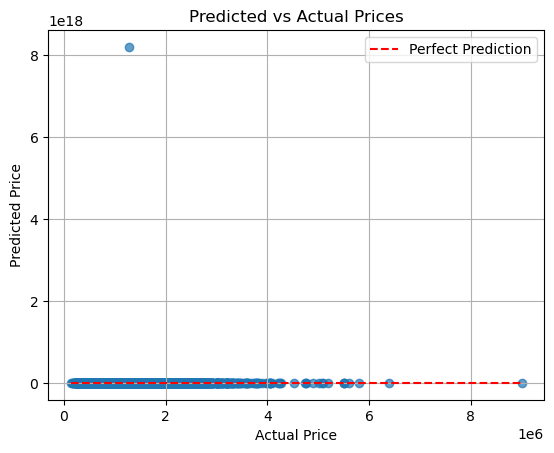

In [59]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

Axis on different scales is never a good sign